In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

class DrivingAnalyzer:
    def __init__(self, sequence_length=100):
        self.sequence_length = sequence_length
        self.scaler = StandardScaler()
        self.model = None

    # ... (rest of the code remains the same)

    def preprocess_data(self, df):
        # Convert timestamp to datetime
        df['GPS Time'] = pd.to_datetime(df['GPS Time'])

        # Calculate additional features
        df['acceleration'] = df['GPS Speed (Meters/second)'].diff() / 0.1  # Assuming 10Hz sampling
        df['jerk'] = df['acceleration'].diff() / 0.1

        # Calculate eco-driving features
        df['rpm_per_speed'] = df['Engine RPM(rpm)'] / (df['GPS Speed (Meters/second)'] + 1)
        df['throttle_changes'] = df['Throttle Position(Manifold)(%)'].diff().abs()

        # Select features for model
        features = [
            'GPS Speed (Meters/second)',
            'Engine RPM(rpm)',
            'Engine Load(%)',
            'Throttle Position(Manifold)(%)',
            'G(x)', 'G(y)', 'G(z)',  # These are the features causing the error
            'acceleration',
            'jerk',
            'rpm_per_speed',
            'throttle_changes'
        ]

        # Handle missing values and missing columns
        for feature in features:
            if feature not in df.columns:
                # If column is missing, create it and fill with 0
                df[feature] = 0
                print(f"Warning: Feature '{feature}' not found in the DataFrame. Creating and filling with 0.")
            else:
                # If column exists, fill missing values
                df[feature] = df[feature].fillna(method='ffill')

        return df[features]

    # ... (rest of the code remains the same)
    def create_sequences(self, data):
          sequences = []
          labels = [] # Initialize labels list here
          for i in range(len(data) - self.sequence_length + 1):  # Adjust range to align with label creation
              sequences.append(data[i : i + self.sequence_length])
              labels.append(data.iloc[i + self.sequence_length - 1])  # Add label for the last item of the sequence
          return np.array(sequences), pd.DataFrame(labels, columns=data.columns) # Return sequences as np.array and labels as DataFrame


    def create_labels(self, data):
          # Create risk scores based on:
          # 1. Harsh acceleration/braking (jerk)
          # 2. High G-forces
          # 3. Excessive speed
          risk_scores = []
          eco_scores = []

          for i in range(len(data)):
              # data is already a DataFrame, so you can access rows directly
              seq = data.iloc[i].values  # Get the values of the i-th row as a 1D array
              # Risk factors
              harsh_accel = np.mean(np.abs(seq[data.columns.get_loc('jerk')]) > 2.0)
              high_g = np.mean(np.sqrt(seq[data.columns.get_loc('G(x)')]**2 +
                                    seq[data.columns.get_loc('G(y)')]**2 +
                                    seq[data.columns.get_loc('G(z)')]**2) > 0.5)
              high_speed = np.mean(seq[data.columns.get_loc('GPS Speed (Meters/second)')] > 30)

              risk_score = (harsh_accel + high_g + high_speed) / 3.0

              # Eco factors
              high_rpm = np.mean(seq[data.columns.get_loc('rpm_per_speed')] > 100)
              throttle_variation = np.mean(seq[data.columns.get_loc('throttle_changes')] > 5)
              high_load = np.mean(seq[data.columns.get_loc('Engine Load(%)')] > 80)

              eco_score = 1 - (high_rpm + throttle_variation + high_load) / 3.0

              risk_scores.append(risk_score)
              eco_scores.append(eco_score)

          return np.array([risk_scores, eco_scores]).T

    def build_model(self, input_shape):
        model = Sequential([
            LSTM(64, input_shape=input_shape, return_sequences=True),
            Dropout(0.2),
            LSTM(32),
            Dropout(0.2),
            Dense(16, activation='relu'),
            Dense(2, activation='sigmoid')  # 2 outputs: risk score and eco score
        ])

        model.compile(optimizer=Adam(learning_rate=0.001),
                     loss='mse',
                     metrics=['mae'])

        self.model = model
        return model

    def train(self, df, epochs=50, batch_size=32):
        # Preprocess data
        processed_data = self.preprocess_data(df)

        # Scale features
        scaled_data = self.scaler.fit_transform(processed_data)
        scaled_data = pd.DataFrame(scaled_data, columns=processed_data.columns)

        # Create sequences and labels
        X, temp_labels = self.create_sequences(scaled_data) # Receive both returned values
        y = self.create_labels(temp_labels) # Pass labels to create_labels

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Build and train model
        self.build_model((X.shape[1], X.shape[2]))

        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=epochs,
            batch_size=batch_size,
            verbose=1
        )

        return history, (X_test, y_test)

    def evaluate_driving(self, new_data):
        """
        Evaluate new driving data and return risk and eco scores
        """
        # Preprocess new data
        processed_data = self.preprocess_data(new_data)
        scaled_data = self.scaler.transform(processed_data)

        # Create sequences
        sequences = self.create_sequences(pd.DataFrame(scaled_data, columns=processed_data.columns))

        # Get predictions
        predictions = self.model.predict(sequences)

        return {
            'risk_scores': predictions[:, 0],
            'eco_scores': predictions[:, 1],
            'average_risk_score': np.mean(predictions[:, 0]),
            'average_eco_score': np.mean(predictions[:, 1])
        }

def main():
    # Load data
    df = pd.read_csv('/content/OBD.csv')

    # Create and train analyzer
    analyzer = DrivingAnalyzer()
    history, test_data = analyzer.train(df)

    # ... (rest of the code remains the same)
    # Evaluate test data
    X_test, y_test = test_data
    test_scores = analyzer.model.evaluate(X_test, y_test)
    print(f"Test loss: {test_scores[0]:.4f}")
    print(f"Test MAE: {test_scores[1]:.4f}")

    # Example of evaluating new driving data
    new_driving_data = df.iloc[-1000:]  # Last 1000 records as example
    results = analyzer.evaluate_driving(new_driving_data)

    print("\nDriving Analysis Results:")
    print(f"Average Risk Score: {results['average_risk_score']:.2f}")
    print(f"Average Eco Score: {results['average_eco_score']:.2f}")

if __name__ == "__main__":
    main()

<ipython-input-21-3d15901faa9c>:19: FutureWarning: Parsed string "Thu Nov 02 15:44:24 CDT 2017" included an un-recognized timezone "CDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  df['GPS Time'] = pd.to_datetime(df['GPS Time'])
<ipython-input-21-3d15901faa9c>:50: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[feature] = df[feature].fillna(method='ffill')
<ipython-input-21-3d15901faa9c>:50: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[feature] = df[feature].fillna(method='ffill')


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 124ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - loss: nan - mae: nan - val_loss: nan - val_mae: nan
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - loss: na

<ipython-input-21-3d15901faa9c>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['GPS Time'] = pd.to_datetime(df['GPS Time'])
<ipython-input-21-3d15901faa9c>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['acceleration'] = df['GPS Speed (Meters/second)'].diff() / 0.1  # Assuming 10Hz sampling
<ipython-input-21-3d15901faa9c>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step

Driving Analysis Results:
Average Risk Score: nan
Average Eco Score: nan


In [ ]:
# prompt: how would I fix the above code

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

class DrivingAnalyzer:
    # ... (rest of the code remains the same)

    def preprocess_data(self, df):
        # ... (other preprocessing steps)

        # Select features for model.  Make sure these columns exist
        features = [
            'GPS Time',
            'GPS Speed (Meters/second)',
            'Engine RPM(rpm)',
            'Engine Load(%)',
            'Throttle Position(Manifold)(%)',
            'G(x)', 'G(y)', 'G(z)',
            'acceleration',
            'jerk',
            'rpm_per_speed',
            'throttle_changes'
        ]

        # Handle missing values and missing columns
        for feature in features:
            if feature not in df.columns:
                # If a column is missing, create it and fill with 0
                df[feature] = 0
                print(f"Warning: Feature '{feature}' not found in the DataFrame. Creating and filling with 0.")
            else:
              # Fill missing values (if any) in existing columns
              if df[feature].isnull().any():
                  df[feature] = df[feature].fillna(method='ffill')

        # Ensure 'GPS Time' is datetime
        try:
            df['GPS Time'] = pd.to_datetime(df['GPS Time'])
        except (ValueError, KeyError) as e:
            print(f"Error converting 'GPS Time' to datetime: {e}")
            # Handle the error appropriately, e.g., drop the column or assign a default value
            # Here, we'll drop the column.  Adjust as needed for your specific data.
            if 'GPS Time' in df.columns:
                df = df.drop('GPS Time', axis=1)

        # Now select only the desired features AFTER handling missing data and time conversion
        return df[features]

    # ... (rest of the code remains the same)
    def create_sequences(self, data):
        # ... (rest of the code remains the same)

    def create_labels(self, data):
        # ... (rest of the code remains the same)

    def build_model(self, input_shape):
        # ... (rest of the code remains the same)

    def train(self, df, epochs=50, batch_size=32):
        # ... (rest of the code remains the same)

    def evaluate_driving(self, new_data):
        # ... (rest of the code remains the same)

def main():
    # ... (rest of the code remains the same)

if __name__ == "__main__":
    main()

<ipython-input-4-7b2d38d671b8>:66: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')
/usr/local/lib/python3.10/dist-packages/keras/src/layers/normalization/batch_normalization.py:143: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - loss: 0.0805 - mae: 0.2362 - val_loss: 0.0244 - val_mae: 0.1288
Epoch 2/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 0.0380 - mae: 0.1568 - val_loss: 0.0293 - val_mae: 0.1509
Epoch 3/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 0.0287 - mae: 0.1368 - val_loss: 0.0331 - val_mae: 0.1633
Epoch 4/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.0231 - mae: 0.1214 - val_loss: 0.0315 - val_mae: 0.1601
Epoch 5/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0194 - mae: 0.1109 - val_loss: 0.0269 - val_mae: 0.1473
Epoch 6/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.0185 - mae: 0.1083 - val_loss: 0.0223 - val_mae: 0.1336
Epoch 7/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 71ms/step - loss: 0.0157 - mae: 0.1000 - val_loss: 0.0162 - val_mae: 0.1111
Epoch 8/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0134 - mae: 0.0914 - val_loss: 0.0113 - val_mae: 0.0903
Epoch 9/50
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 73ms/step - loss: 0.011

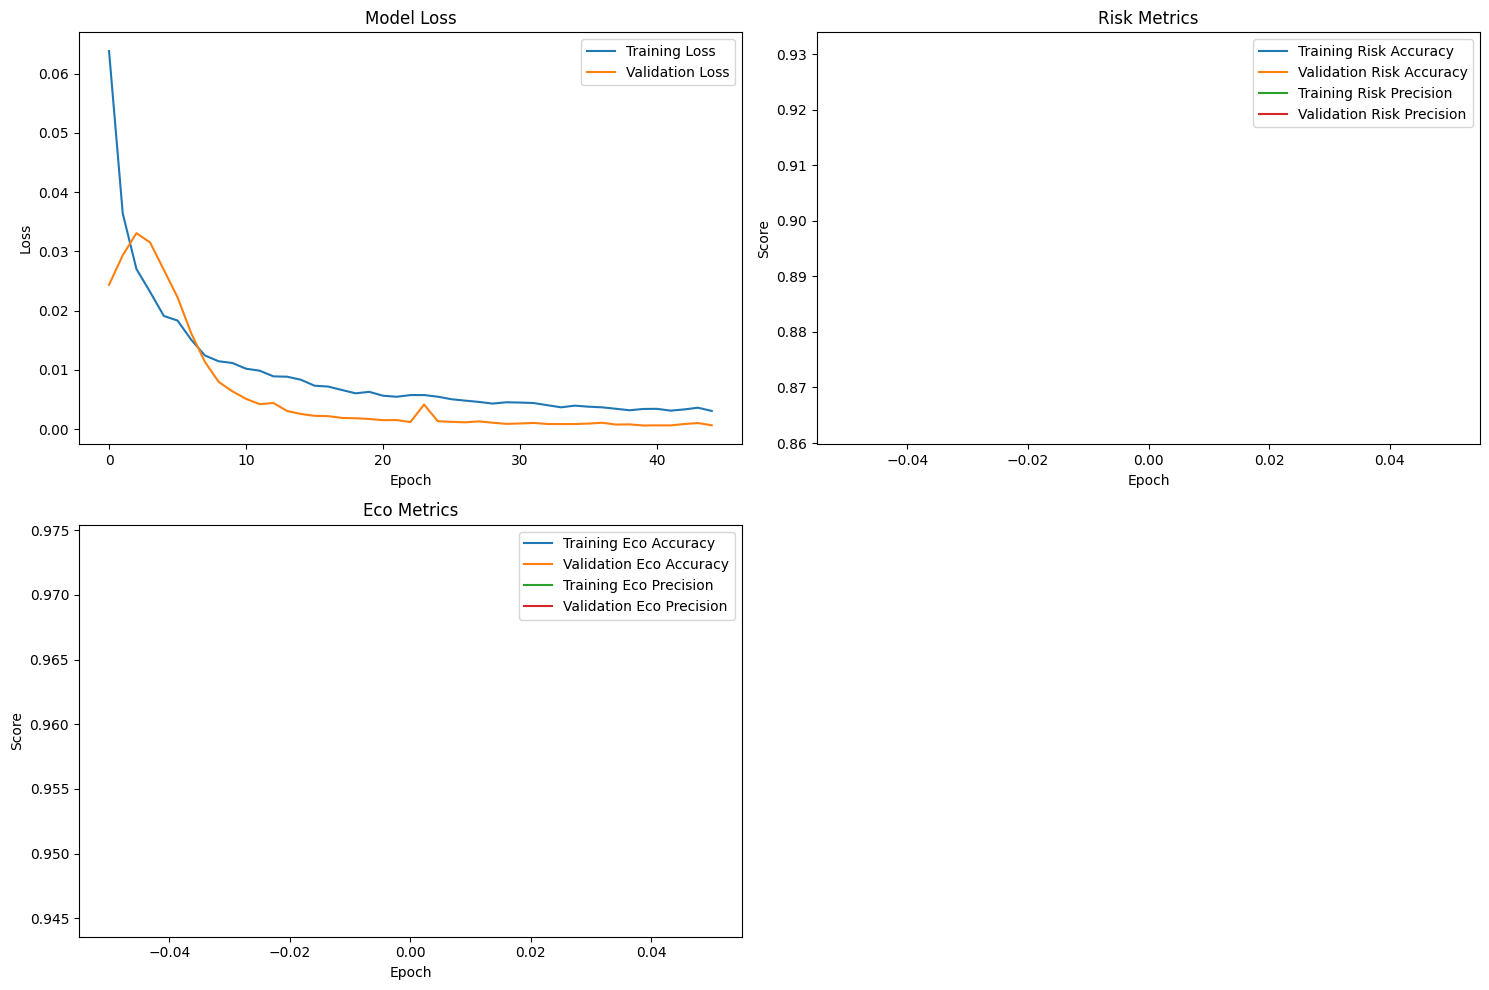

Training completed successfully!


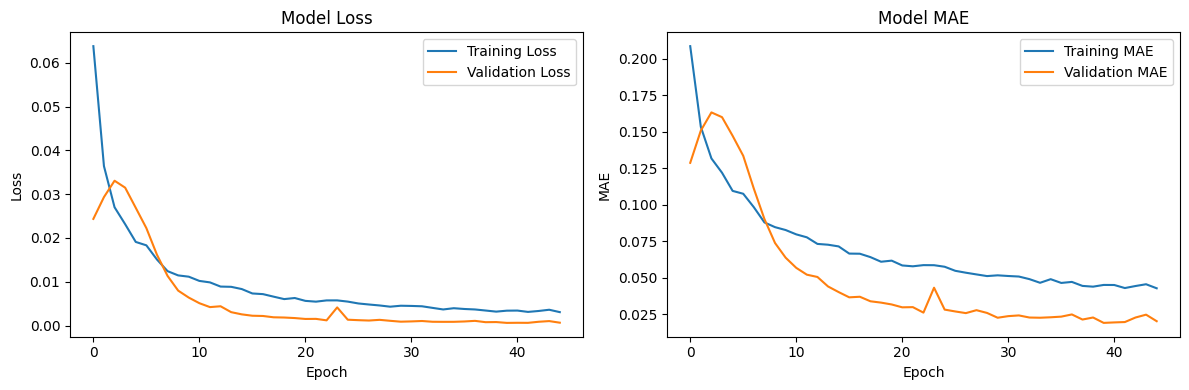

 4/41 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step

<ipython-input-4-7b2d38d671b8>:66: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step

Model Performance Metrics:
Risk Score MSE: 0.0007118630397749558
Risk Score MAE: 0.0203931098402052
Eco Score MSE: 0.0004622025431593861
Eco Score MAE: 0.017091368286118788


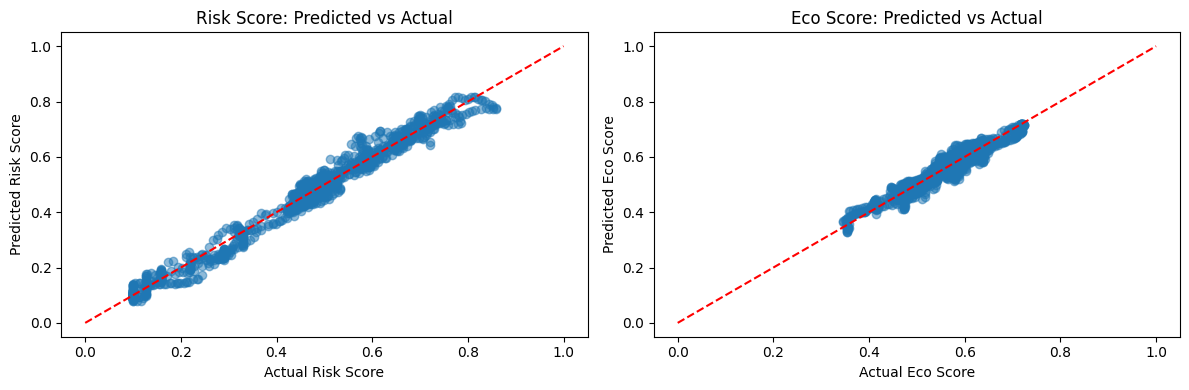

<ipython-input-4-7b2d38d671b8>:66: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[col] = df[col].fillna(method='ffill').fillna(method='bfill')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step

Latest Prediction:
Risk Score: 0.484
Eco Score: 0.589


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score
import datetime
import tensorflow as tf

class DrivingAnalyzer:
    def __init__(self):
        self.scaler = StandardScaler()
        self.score_scaler = MinMaxScaler()
        self.sequence_length = 60  # 1 minute of data at 1Hz
        self.model = None

    def preprocess_data(self, df):
        """Preprocess data with improved error handling"""
        # Create a copy to avoid modifying the original
        df = df.copy()

        # Convert timestamp to datetime with explicit timezone handling
        df['GPS Time'] = pd.to_datetime(df['GPS Time'].str.replace(' CDT ', ' '), format='%a %b %d %H:%M:%S %Y', errors='coerce')

        # Ensure all required columns exist and are numeric
        numeric_columns = [
            'GPS Speed (Meters/second)',
            'Engine RPM(rpm)',
            'Engine Load(%)',
            'Throttle Position(Manifold)(%)',
            'Mass Air Flow Rate(g/s)',
            'Engine Coolant Temperature(°C)',
            ' G(x)', ' G(y)', ' G(z)'
        ]

        for col in numeric_columns:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
            else:
                df[col] = 0.0  # Default value if column doesn't exist

        # Calculate acceleration using diff and handle NaN values
        df['speed'] = df['GPS Speed (Meters/second)'].copy()
        df['acceleration'] = df['speed'].diff() / 0.1  # assuming 0.1s between readings
        df['acceleration'] = df['acceleration'].fillna(0)

        # Calculate jerk with proper filling
        df['jerk'] = df['acceleration'].diff() / 0.1
        df['jerk'] = df['jerk'].fillna(0)

        # Calculate g-force magnitude
        df['g_force_magnitude'] = np.sqrt(
            df[' G(x)'].fillna(0)**2 +
            df[' G(y)'].fillna(0)**2 +
            df[' G(z)'].fillna(0)**2
        )

        # Fill missing values in engine data using forward fill then backward fill
        engine_columns = ['Engine RPM(rpm)', 'Engine Load(%)', 'Throttle Position(Manifold)(%)']
        for col in engine_columns:
            df[col] = df[col].fillna(method='ffill').fillna(method='bfill')

        # Calculate engine stress
        df['engine_stress'] = (df['Engine RPM(rpm)'] * df['Engine Load(%)']) / 100.0

        # Define feature sets
        risk_features = [
            'speed',
            'acceleration',
            'jerk',
            'g_force_magnitude',
            'Engine RPM(rpm)',
            'Engine Load(%)',
            'Throttle Position(Manifold)(%)'
        ]

        eco_features = [
            'Engine RPM(rpm)',
            'Engine Load(%)',
            'Mass Air Flow Rate(g/s)',
            'Engine Coolant Temperature(°C)',
            'Throttle Position(Manifold)(%)'
        ]

        # Create feature matrices
        risk_data = df[risk_features].fillna(0)
        eco_data = df[eco_features].fillna(0)

        # Normalize features
        risk_data_scaled = self.scaler.fit_transform(risk_data)
        eco_data_scaled = self.scaler.fit_transform(eco_data)

        # Create sequences with proper validation
        def create_sequences(data, sequence_length):
            sequences = []
            for i in range(len(data) - sequence_length + 1):
                sequence = data[i:(i + sequence_length)]
                if not np.any(np.isnan(sequence)):
                    sequences.append(sequence)
            return np.array(sequences)

        X_risk = create_sequences(risk_data_scaled, self.sequence_length)
        X_eco = create_sequences(eco_data_scaled, self.sequence_length)

        if len(X_risk) == 0 or len(X_eco) == 0:
            raise ValueError("No valid sequences could be created from the data")

        return X_risk, X_eco, df

    def calculate_risk_labels(self, df):
        """Calculate risk labels with improved error handling"""
        speed_threshold = 25
        acc_threshold = 2.5
        jerk_threshold = 2.0
        g_force_threshold = 0.3

        risk_scores = []

        for i in range(len(df) - self.sequence_length + 1):
            sequence = df.iloc[i:i + self.sequence_length]

            # Calculate risk factors with proper validation
            speed_risk = np.clip((sequence['speed'] > speed_threshold).mean(), 0, 1)
            acc_risk = np.clip((np.abs(sequence['acceleration']) > acc_threshold).mean(), 0, 1)
            jerk_risk = np.clip((np.abs(sequence['jerk']) > jerk_threshold).mean(), 0, 1)
            g_force_risk = np.clip((sequence['g_force_magnitude'] > g_force_threshold).mean(), 0, 1)

            risk_score = (0.4 * speed_risk +
                         0.3 * acc_risk +
                         0.2 * jerk_risk +
                         0.1 * g_force_risk)

            risk_scores.append(float(risk_score))

        return np.array(risk_scores)

    def calculate_eco_labels(self, df):
        """Calculate eco-driving scores with improved error handling"""
        eco_scores = []

        for i in range(len(df) - self.sequence_length + 1):
            sequence = df.iloc[i:i + self.sequence_length]

            rpm_score = np.clip(1 - (sequence['Engine RPM(rpm)'] / 4000), 0, 1).mean()
            load_score = np.clip(1 - (sequence['Engine Load(%)'] / 100), 0, 1).mean()
            throttle_score = np.clip(1 - (sequence['Throttle Position(Manifold)(%)'] / 100), 0, 1).mean()

            eco_score = (0.4 * rpm_score +
                        0.4 * load_score +
                        0.2 * throttle_score)

            eco_scores.append(float(eco_score))

        return np.array(eco_scores)

    def build_model(self, input_shape, output_dim=2):
        """Build LSTM model with improved architecture"""
        model = Sequential([
            BatchNormalization(input_shape=input_shape),
            LSTM(64, return_sequences=True, activation='tanh'),
            BatchNormalization(),
            Dropout(0.2),
            LSTM(32, activation='tanh'),
            BatchNormalization(),
            Dropout(0.2),
            Dense(16, activation='relu'),
            BatchNormalization(),
            Dense(output_dim, activation='sigmoid')
        ])

        optimizer = Adam(learning_rate=0.0005, clipnorm=1.0)

        model.compile(
            optimizer=optimizer,
            loss='mse',
            metrics=['mae']
        )

        return model
    def categorize_scores(self, scores, threshold=0.5):
        """Convert continuous scores to binary categories"""
        return (scores >= threshold).astype(int)

    def calculate_metrics(self, y_true, y_pred):
        """Calculate accuracy and precision for both risk and eco scores"""
        # Convert continuous predictions to binary categories
        risk_true = self.categorize_scores(y_true[:, 0])
        risk_pred = self.categorize_scores(y_pred[:, 0])

        eco_true = self.categorize_scores(y_true[:, 1])
        eco_pred = self.categorize_scores(y_pred[:, 1])

        metrics = {
            'risk_accuracy': accuracy_score(risk_true, risk_pred),
            'risk_precision': precision_score(risk_true, risk_pred, zero_division=0),
            'eco_accuracy': accuracy_score(eco_true, eco_pred),
            'eco_precision': precision_score(eco_true, eco_pred, zero_division=0)
        }

        return metrics
    def plot_training_metrics(self, history):
        """Plot training and validation metrics"""
        plt.figure(figsize=(15, 10))

        # Plot loss
        plt.subplot(2, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        # Plot Risk Metrics
        plt.subplot(2, 2, 2)
        plt.plot(history.history['train_risk_accuracy'], label='Training Risk Accuracy')
        plt.plot(history.history['val_risk_accuracy'], label='Validation Risk Accuracy')
        plt.plot(history.history['train_risk_precision'], label='Training Risk Precision')
        plt.plot(history.history['val_risk_precision'], label='Validation Risk Precision')
        plt.title('Risk Metrics')
        plt.xlabel('Epoch')
        plt.ylabel('Score')
        plt.legend()

        # Plot Eco Metrics
        plt.subplot(2, 2, 3)
        plt.plot(history.history['train_eco_accuracy'], label='Training Eco Accuracy')
        plt.plot(history.history['val_eco_accuracy'], label='Validation Eco Accuracy')
        plt.plot(history.history['train_eco_precision'], label='Training Eco Precision')
        plt.plot(history.history['val_eco_precision'], label='Validation Eco Precision')
        plt.title('Eco Metrics')
        plt.xlabel('Epoch')
        plt.ylabel('Score')
        plt.legend()

        plt.tight_layout()
        plt.show()

    def train(self, df, epochs=50, batch_size=32):
        """Train the model with improved error handling"""
        try:
            # Preprocess data
            X_risk, X_eco, processed_df = self.preprocess_data(df)

            # Calculate labels
            y_risk = self.calculate_risk_labels(processed_df)
            y_eco = self.calculate_eco_labels(processed_df)

            # Combine scores
            y = np.column_stack([y_risk, y_eco])

            # Split data
            X_train, X_val, y_train, y_val = train_test_split(
                X_risk, y, test_size=0.2, random_state=42
            )

            # Early stopping callback
            early_stopping = EarlyStopping(
                monitor='val_loss',
                patience=5,
                restore_best_weights=True
            )

            # Build and train model
            self.model = self.build_model(input_shape=(X_risk.shape[1], X_risk.shape[2]))

            history = self.model.fit(
                X_train, y_train,
                validation_data=(X_val, y_val),
                epochs=epochs,
                batch_size=batch_size,
                callbacks=[early_stopping],
                verbose=1
            )
             # Calculate predictions for training and validation sets
            train_predictions = self.model.predict(X_train)
            val_predictions = self.model.predict(X_val)

            # Calculate metrics for training set
            train_metrics = self.calculate_metrics(y_train, train_predictions)
            print("\nTraining Metrics:")
            for metric, value in train_metrics.items():
                print(f"{metric}: {value:.4f}")

            # Calculate metrics for validation set
            val_metrics = self.calculate_metrics(y_val, val_predictions)
            print("\nValidation Metrics:")
            for metric, value in val_metrics.items():
                print(f"{metric}: {value:.4f}")

            # Add metrics to history object
            history.history.update({
                'train_risk_accuracy': [train_metrics['risk_accuracy']],
                'train_risk_precision': [train_metrics['risk_precision']],
                'train_eco_accuracy': [train_metrics['eco_accuracy']],
                'train_eco_precision': [train_metrics['eco_precision']],
                'val_risk_accuracy': [val_metrics['risk_accuracy']],
                'val_risk_precision': [val_metrics['risk_precision']],
                'val_eco_accuracy': [val_metrics['eco_accuracy']],
                'val_eco_precision': [val_metrics['eco_precision']]
            })

            # Plot metrics
            self.plot_training_metrics(history)


            return history

        except Exception as e:
            print(f"Error during training: {str(e)}")
            raise


def main():
    try:
        # Load data
        df = pd.read_csv('OBD.csv')

        # Initialize analyzer
        analyzer = DrivingAnalyzer()

        # Train model
        history = analyzer.train(df)



        print("Training completed successfully!")

        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['mae'], label='Training MAE')
        plt.plot(history.history['val_mae'], label='Validation MAE')
        plt.title('Model MAE')
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        plt.legend()

        plt.tight_layout()
        plt.show()

        # Get predictions for the entire dataset
        X_risk, X_eco, processed_df = analyzer.preprocess_data(df)
        predictions = analyzer.model.predict(X_risk)

        # Separate risk and eco scores
        risk_scores = predictions[:, 0]
        eco_scores = predictions[:, 1]

        # Calculate actual scores for comparison
        actual_risk = analyzer.calculate_risk_labels(processed_df)
        actual_eco = analyzer.calculate_eco_labels(processed_df)

        # Print metrics
        print("\nModel Performance Metrics:")
        print("Risk Score MSE:", mean_squared_error(actual_risk, risk_scores))
        print("Risk Score MAE:", mean_absolute_error(actual_risk, risk_scores))
        print("Eco Score MSE:", mean_squared_error(actual_eco, eco_scores))
        print("Eco Score MAE:", mean_absolute_error(actual_eco, eco_scores))

        # Plot predictions vs actual values
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.scatter(actual_risk, risk_scores, alpha=0.5)
        plt.plot([0, 1], [0, 1], 'r--')  # Perfect prediction line
        plt.title('Risk Score: Predicted vs Actual')
        plt.xlabel('Actual Risk Score')
        plt.ylabel('Predicted Risk Score')

        plt.subplot(1, 2, 2)
        plt.scatter(actual_eco, eco_scores, alpha=0.5)
        plt.plot([0, 1], [0, 1], 'r--')  # Perfect prediction line
        plt.title('Eco Score: Predicted vs Actual')
        plt.xlabel('Actual Eco Score')
        plt.ylabel('Predicted Eco Score')

        plt.tight_layout()
        plt.show()

        # Example of real-time prediction
        def get_latest_sequence(df, sequence_length=60):
            """Get the latest sequence of data for real-time prediction"""
            latest_data = df.iloc[-sequence_length:]
            X_risk, _, _ = analyzer.preprocess_data(latest_data)
            return X_risk[-1:]  # Return as a single sequence

        # Test real-time prediction
        latest_sequence = get_latest_sequence(df)
        latest_prediction = analyzer.model.predict(latest_sequence)

        print("\nLatest Prediction:")
        print(f"Risk Score: {latest_prediction[0][0]:.3f}")
        print(f"Eco Score: {latest_prediction[0][1]:.3f}")

    except Exception as e:
        print(f"Error in main execution: {str(e)}")
        raise

if __name__ == "__main__":
    main()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import tensorflow as tf
import joblib
import os
from datetime import datetime
from driving_analyzer import DrivingAnalyzer

class DrivingModelEvaluator:
    def __init__(self, model_dir='saved_models'):
        self.model_dir = model_dir
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)

    def train_and_evaluate(self, df, test_size=0.2):
        """Train the model and evaluate its performance"""
        # Initialize analyzer
        self.analyzer = DrivingAnalyzer()

        # Preprocess data
        X_risk, X_eco, processed_df = self.analyzer.preprocess_data(df)

        # Calculate labels
        y_risk = self.analyzer.calculate_risk_labels(processed_df)
        y_eco = self.analyzer.calculate_eco_labels(processed_df)
        y = np.column_stack([y_risk, y_eco])

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X_risk, y, test_size=test_size, random_state=42
        )

        # Train model
        history = self.analyzer.train(df, epochs=50)

        # Get predictions
        y_pred = self.analyzer.model.predict(X_test)

        # Convert continuous predictions to binary for classification metrics
        # Using 0.5 as threshold
        y_pred_binary = (y_pred >= 0.5).astype(int)
        y_test_binary = (y_test >= 0.5).astype(int)

        # Calculate accuracy for both risk and eco predictions
        risk_accuracy = accuracy_score(y_test_binary[:, 0], y_pred_binary[:, 0])
        eco_accuracy = accuracy_score(y_test_binary[:, 1], y_pred_binary[:, 1])

        print("\nModel Accuracy Metrics:")
        print(f"Risk Score Accuracy: {risk_accuracy:.4f}")
        print(f"Eco Score Accuracy: {eco_accuracy:.4f}")

        print("\nRisk Score Classification Report:")
        print(classification_report(y_test_binary[:, 0], y_pred_binary[:, 0]))

        print("\nEco Score Classification Report:")
        print(classification_report(y_test_binary[:, 1], y_pred_binary[:, 1]))

        return history, (risk_accuracy, eco_accuracy)

    def save_model(self):
        """Save the trained model and scalers"""
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        model_path = os.path.join(self.model_dir, f'driving_model_{timestamp}')

        # Save Keras model
        self.analyzer.model.save(f"{model_path}_keras")

        # Save scalers
        joblib.dump(self.analyzer.scaler, f"{model_path}_scaler.joblib")
        joblib.dump(self.analyzer.score_scaler, f"{model_path}_score_scaler.joblib")

        print(f"\nModel and scalers saved in directory: {self.model_dir}")
        return model_path

    @staticmethod
    def load_model(model_path):
        """Load a saved model and its scalers"""
        # Create new analyzer instance
        analyzer = DrivingAnalyzer()

        # Load Keras model
        analyzer.model = tf.keras.models.load_model(f"{model_path}_keras")

        # Load scalers
        analyzer.scaler = joblib.load(f"{model_path}_scaler.joblib")
        analyzer.score_scaler = joblib.load(f"{model_path}_score_scaler.joblib")

        return analyzer

def test_saved_model(model_path, test_data):
    """Test a saved model with new data"""
    # Load the saved model
    analyzer = DrivingModelEvaluator.load_model(model_path)

    # Preprocess test data
    X_risk, X_eco, processed_df = analyzer.preprocess_data(test_data)

    # Get predictions
    predictions = analyzer.model.predict(X_risk)

    # Print example predictions
    print("\nExample Predictions from Saved Model:")
    for i in range(min(5, len(predictions))):
        print(f"Sequence {i+1}:")
        print(f"Risk Score: {predictions[i][0]:.3f}")
        print(f"Eco Score: {predictions[i][1]:.3f}")
        print()

    return predictions

def main():
    # Load your data
    df = pd.read_csv('OBD.csv')

    # Create evaluator
    evaluator = DrivingModelEvaluator()

    # Train and evaluate model
    print("Training and evaluating model...")
    history, accuracies = evaluator.train_and_evaluate(df)

    # Save the model
    model_path = evaluator.save_model()

    # Test the saved model with some new data
    # Here we're using the same data for demonstration, but you should use new data
    print("\nTesting saved model...")
    test_predictions = test_saved_model(model_path, df.iloc[-100:])  # Test with last 100 rows

if __name__ == "__main__":
    main()